In [ ]:
!pip install transformers torch sklearn pandas openpyxl matplotlib scikit-plot
!pip install datasets
!pip install --upgrade transformers
!pip install --upgrade sympy




  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import pandas as pd
from datasets import Dataset
import torch

# wandb'yi devre dışı bırak
os.environ["WANDB_DISABLED"] = "true"

# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Eğitim ve test veri setlerini yükleme
train_file_path = "/content/drive/MyDrive/30_data_set/30_train/sorted_final_merged_train.xlsx"
test_file_path = "/content/drive/MyDrive/30_data_set/30_test/sorted_final_merged_test.xlsx"

train_data = pd.read_excel(train_file_path).dropna()
test_data = pd.read_excel(test_file_path).dropna()

# Eğitim ve test veri setlerini DataFrame formatına dönüştürme
train_df = pd.DataFrame({"text": train_data['poem_text'], "label": train_data['label']})
test_df = pd.DataFrame({"text": test_data['poem_text'], "label": test_data['label']})

# Dataset formatına dönüştürme
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/11482 [00:00<?, ? examples/s]

Map:   0%|          | 0/4916 [00:00<?, ? examples/s]

Map:   0%|          | 0/11482 [00:00<?, ? examples/s]

Map:   0%|          | 0/4916 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-4e90693d13aa>:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.776500,0.689661
2,0.515200,0.607577
3,0.467700,0.630665
4,0.380500,0.675810


Eğitim süresi: 300.25 saniye


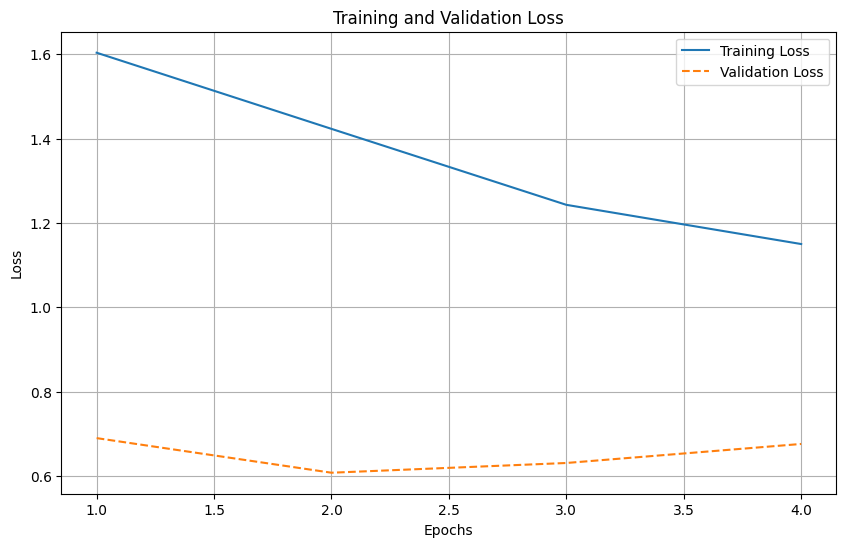

In [ ]:
# Model ve tokenizer yükleme (BERT tabanlı Türkçe model)
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizer ayarları (padding token tanımlama)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Modeli yükleme
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=train_data['label'].nunique()
)

# Tokenizer'daki değişikliklere model uyum sağlar
model.resize_token_embeddings(len(tokenizer))

# GPU kontrolü ve cihaz seçimi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Tokenizasyon fonksiyonu
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Tokenizasyon işlemi
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Modelin etiketleri kullanabilmesi için label formatını güncelleme
def format_labels(examples):
    examples["labels"] = examples["label"]
    return examples

train_dataset = train_dataset.map(format_labels, batched=True)
test_dataset = test_dataset.map(format_labels, batched=True)

# Eğitim ayarları
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Mixed precision training
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=1e-5
)

# Eğitim süresi ölçümü
start_training_time = time.time()

# Trainer oluşturma
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Model eğitimi
training_logs = trainer.train()

# Eğitim süresini ölçme
end_training_time = time.time()
total_training_time = end_training_time - start_training_time
print(f"Eğitim süresi: {total_training_time:.2f} saniye")

# Modeli kaydetme
trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

# Eğitim ve doğrulama loss grafikleri
log_history = trainer.state.log_history
train_losses = [log["loss"] for log in log_history if "loss" in log]
val_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]

# Minimum uzunluğu bul
min_length = min(len(train_losses), len(val_losses))

# Epochs aralığını minimum uzunluğa göre ayarla
epochs = range(1, min_length + 1)

# Grafikleri çizin
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses[:min_length], label="Training Loss")
plt.plot(epochs, val_losses[:min_length], label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Çıkarım süresi ölçümü
inference_start_time = time.time()

Çıkarım süresi: 1142.01 saniye
Confusion Matrix:
 [[823  20  47  44  50]
 [ 25 762 125  22  47]
 [ 31  62 750  59  82]
 [ 27   9  95 793  60]
 [ 36  23  86  83 755]]


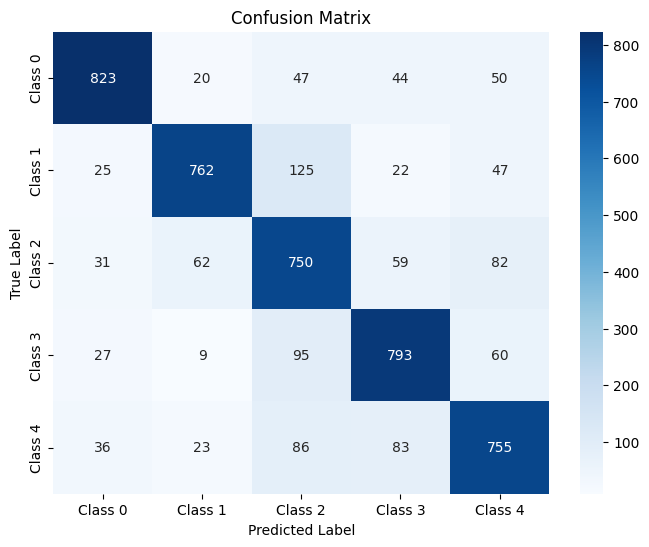

Accuracy: 0.7898698128559805
              precision    recall  f1-score   support

     Class 0       0.87      0.84      0.85       984
     Class 1       0.87      0.78      0.82       981
     Class 2       0.68      0.76      0.72       984
     Class 3       0.79      0.81      0.80       984
     Class 4       0.76      0.77      0.76       983

    accuracy                           0.79      4916
   macro avg       0.80      0.79      0.79      4916
weighted avg       0.80      0.79      0.79      4916

Sensitivity ve Specificity Sonuçları: {'Class 0': {'Sensitivity': 0.8363821138211383, 'Specificity': 0.969735503560529}, 'Class 1': {'Sensitivity': 0.7767584097859327, 'Specificity': 0.9710292249047014}, 'Class 2': {'Sensitivity': 0.7621951219512195, 'Specificity': 0.9102238046795524}, 'Class 3': {'Sensitivity': 0.8058943089430894, 'Specificity': 0.9471007121057986}, 'Class 4': {'Sensitivity': 0.768056968463886, 'Specificity': 0.9392321383168065}}


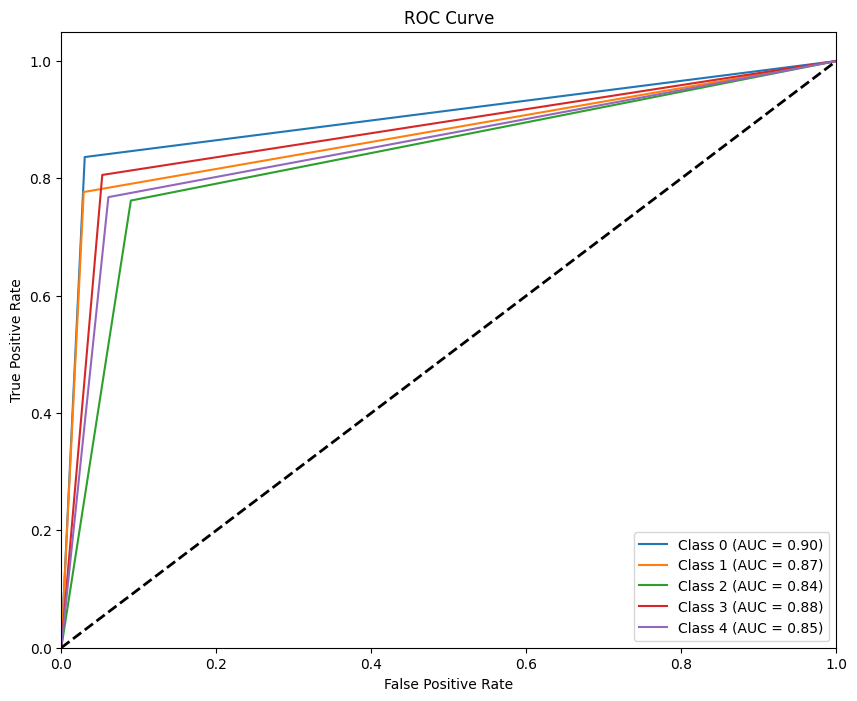

Macro AUC: 0.8686608306532653


In [ ]:
import seaborn as sns

# Modeli test moduna al
model.eval()

# Tahminleri alma
predictions, labels, _ = trainer.predict(test_dataset)

inference_end_time = time.time()
inference_time = inference_end_time - inference_start_time
print(f"Çıkarım süresi: {inference_time:.2f} saniye")

# Gerçek ve tahmin edilen etiketleri al
true_labels = labels
predictions = np.argmax(predictions, axis=1)

# Confusion Matrix oluşturma
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(cm.shape[0])], yticklabels=[f'Class {i}' for i in range(cm.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy hesaplama
accuracy = np.trace(cm) / float(np.sum(cm))
print("Accuracy:", accuracy)

# Precision, Recall, F-Score gibi metrikler
report = classification_report(true_labels, predictions, target_names=[f'Class {i}' for i in range(len(np.unique(true_labels)))] )
print(report)

# Sensitivity ve Specificity hesaplama
def compute_sensitivity_specificity(cm):
    metrics = {}
    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        metrics[f"Class {i}"] = {"Sensitivity": sensitivity, "Specificity": specificity}
    return metrics

sensitivity_specificity = compute_sensitivity_specificity(cm)
print("Sensitivity ve Specificity Sonuçları:", sensitivity_specificity)

# AUC (Area Under Curve) hesaplama
classes = np.unique(true_labels)
y_true_binary = label_binarize(true_labels, classes=classes)
y_pred_binary = label_binarize(predictions, classes=classes)

# AUC ve ROC eğrisi için değerleri hesaplama
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Eğrisini Çizme
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Ortalama AUC Hesaplama
macro_auc = roc_auc_score(y_true_binary, y_pred_binary, average="macro")
print("Macro AUC:", macro_auc)


In [ ]:
# Google Drive'a model kaydetme
model_save_path = "/content/drive/MyDrive/best_bert_base_turkish_model"

# Modeli ve tokenizer'ı kaydet
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model ve tokenizer Google Drive'a kaydedildi: {model_save_path}")


Model ve tokenizer Google Drive'a kaydedildi: /content/drive/MyDrive/best_bert_base_turkish_model


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

# Daha önce kaydedilmiş modeli ve tokenizer'ı yükleme
model_path = "/content/drive/MyDrive/best_bert_base_turkish_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Modeli cihazınıza aktarın (GPU varsa GPU'yu kullanır)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Modeli değerlendirme moduna alın
model.eval()

# Tahmin yapma fonksiyonu
def predict_poem_category(text):
    # Metni tokenleştirme
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    # Modelden tahmin alın
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()

    return predicted_class

# Sınıf etiketlerini tanımlayın (modelinize göre düzenleyin)
class_labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]

# Örnek metinle tahmin yapma
sample_text = "Bu bir örnek şiir metnidir."
predicted_class = predict_poem_category(sample_text)
print(f"Tahmin edilen sınıf: {class_labels[predicted_class]}")
